# Create a Siamese Network with Triplet Loss in Keras

### Item recognition 1 - using Siamese Network and Triplet Loss with small CNN

# Task 1: Understanding the Approach

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
%matplotlib notebook

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
from numpy.random import default_rng

#from pca_plotter import PCAPlotter

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.2.0


In [3]:
#tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

[]

In [4]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# Task 2: Importing the Data

In [5]:
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
#print(x_train.shape)

In [6]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input, BatchNormalization, Activation
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [7]:
image_dir = "image_data"
train_dir = os.path.join(image_dir, "train")
print(train_dir)
print("items = {}".format(len(os.listdir(train_dir))))

image_data/train
items = 706


In [8]:
all_images = 0
class_list = sorted(os.listdir(train_dir))
for i in class_list:
    #print(i)
    all_images += len(os.listdir(os.path.join(train_dir, i)))
print("All image files = {}".format(all_images))
print("class_list[:10] = {}".format(class_list[:10]))

All image files = 12070
class_list[:10] = ['aubeer2_0', 'aubeer2_1', 'aubeer2_10', 'aubeer2_11', 'aubeer2_12', 'aubeer2_14', 'aubeer2_15', 'aubeer2_16', 'aubeer2_17', 'aubeer2_18']


In [9]:
#_BATCH_SIZE = 1024
#_BATCH_SIZE = 256
_BATCH_SIZE = 32

# Task 3: Plotting Examples

In [10]:
def plot_triplets(examples):

    #plt.figure(figsize=(6, 6))
    fig, axs = plt.subplots(len(examples[0]), 3)
                            
    for i in range(len(examples[0])):
        
        for j in range(len(examples)):
            #print("i = {}, j = {}".format(i, j))
            #plt.subplot(3, 3, 1 + i + j)
            axs[j, i].imshow(examples[i][j])
            plt.xticks([])
            plt.yticks([])
        #plt.title(examples[1][i])
    plt.show()

# Task 4: A Batch of Triplets

In [11]:
def create_batch(batch_size=_BATCH_SIZE):
    rng = default_rng()

    x_anc = np.zeros((batch_size, 224, 224, 3))
    x_pos = np.zeros((batch_size, 224, 224, 3))
    x_neg = np.zeros((batch_size, 224, 224, 3))
    
    rand_classes = rng.choice(len(class_list), batch_size, replace=True)
    
    for i in range(batch_size):
        class_idx = rand_classes[i]
        anc_class_dir = os.path.join(train_dir, class_list[class_idx])
        anc_imglist = os.listdir(anc_class_dir)
        anc_pos_idx = rng.choice(len(anc_imglist), 2, replace=False)
        
        img_anc = tf.keras.preprocessing.image.load_img(os.path.join(anc_class_dir, anc_imglist[anc_pos_idx[0]]))
        img_anc = img_anc.resize((224, 224))
        img_anc = tf.keras.preprocessing.image.img_to_array(img_anc)
        
        img_pos = tf.keras.preprocessing.image.load_img(os.path.join(anc_class_dir, anc_imglist[anc_pos_idx[1]]))
        img_pos = img_pos.resize((224, 224))
        img_pos = tf.keras.preprocessing.image.img_to_array(img_pos)
        
        # Select negative class (!= class_idx)
        all_class_idx = np.arange(len(class_list))
        neg_mask = (all_class_idx != class_idx)
        
        all_neg_classes = all_class_idx[neg_mask]
        neg_class_idx = rng.choice(all_neg_classes)
        
        neg_class_dir = os.path.join(train_dir, class_list[neg_class_idx])
        neg_imglist = os.listdir(neg_class_dir)
        neg_idx = rng.choice(len(neg_imglist))
        
        img_neg = tf.keras.preprocessing.image.load_img(os.path.join(neg_class_dir, neg_imglist[neg_idx]))
        img_neg = img_neg.resize((224, 224))
        img_neg = tf.keras.preprocessing.image.img_to_array(img_neg)
        
        x_anc[i] = img_anc/255.
        x_pos[i] = img_pos/255.
        x_neg[i] = img_neg/255.
    
    return [x_anc, x_pos, x_neg]

<IPython.core.display.Javascript object>


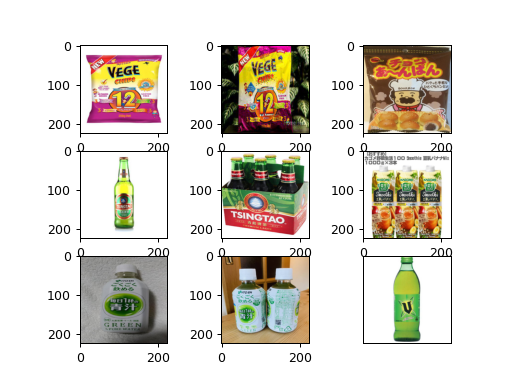

In [12]:
exp_triplet = create_batch(3)
#exp_triplet = np.squeeze(exp_triplet)
plot_triplets(exp_triplet)

# Task 5: Embedding Model

In [13]:
#emb_size = 64

#embedding_model = tf.keras.models.Sequential([
#    tf.keras.layers.Dense(64, activation='relu', input_shape=(784,)),
#    tf.keras.layers.Dense(emb_size, activation='sigmoid')
#])

#embedding_model.summary()

In [14]:
emb_size = 128

# Build a Small Convnet from scratch

img_input = Input(shape=(224, 224, 3))

# Conv2D: data_format = "channels_last" (shape = (batch, height, width, channels))
# conv layer 1
x = Conv2D(16, 3, padding='same')(img_input)
x = BatchNormalization(axis = 3, name = 'bn0')(x)
x = Activation('relu')(x)
x = MaxPooling2D(2)(x)
# 112 * 112 * 16

# conv layer 2
x = Conv2D(32, 3, padding='same')(x)
#x = BatchNormalization(axis = 3, name = 'bn1')(x)
x = Activation('relu')(x)
x = MaxPooling2D(2)(x)
# 56 * 56 * 32

# conv layer 3
x = Conv2D(64, 3, padding='same')(x)
#x = BatchNormalization(axis = 3, name = 'bn2')(x)
x = Activation('relu')(x)
x = MaxPooling2D(2)(x)
# 28 * 28 * 64

# conv layer 4
x = Conv2D(128, 3, padding='same')(x)
#x = BatchNormalization(axis = 3, name = 'bn3')(x)
x = Activation('relu')(x)
x = MaxPooling2D(2)(x)
# 14 * 14 * 128

x = Flatten()(x)
#x = Dense(512, activation='relu')(x)
output = Dense(emb_size, activation='sigmoid')(x)

embedding_model = Model(img_input, output)

In [15]:
embedding_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
bn0 (BatchNormalization)     (None, 224, 224, 16)      64        
_________________________________________________________________
activation (Activation)      (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 32)      0     

In [16]:
#example = np.expand_dims(x_train[0], axis=0)
example_emb = embedding_model.predict(exp_triplet)[0]

print(example_emb)

[0.5256136  0.45930582 0.5018918  0.47051528 0.5012666  0.5149017
 0.4650907  0.5162638  0.5155344  0.4996796  0.5089719  0.48732725
 0.4459983  0.46813315 0.508418   0.5227927  0.46869522 0.48555058
 0.49035847 0.52528644 0.4736996  0.46904078 0.52576876 0.45378482
 0.5057716  0.5098558  0.48886493 0.4847724  0.50091225 0.4827315
 0.5396775  0.49207556 0.5069209  0.5455265  0.49819395 0.5335306
 0.4753055  0.50317866 0.48069757 0.5104801  0.53939354 0.5138563
 0.4817961  0.5185704  0.47495547 0.46754712 0.49751824 0.5223791
 0.52668    0.52745044 0.49934492 0.5261333  0.5207693  0.47084492
 0.4802289  0.5306973  0.49869794 0.53002304 0.5247192  0.52241564
 0.50917196 0.47564602 0.53189194 0.49069595 0.50163347 0.47937357
 0.45362797 0.53466094 0.49478748 0.49384812 0.5202527  0.52174145
 0.5201133  0.52305394 0.48053727 0.5064898  0.46655846 0.53024864
 0.49222755 0.52533865 0.5013965  0.5027653  0.48958975 0.48000985
 0.5040267  0.49123225 0.5225508  0.49548256 0.49091497 0.49023318


# Task 6: Siamese Network

In [17]:
input_anchor = tf.keras.layers.Input(shape=(224, 224, 3))
input_positive = tf.keras.layers.Input(shape=(224, 224, 3))
input_negative = tf.keras.layers.Input(shape=(224, 224, 3))

embedding_anchor = embedding_model(input_anchor)
embedding_positive = embedding_model(input_positive)
embedding_negative = embedding_model(input_negative)

all_output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)

net = tf.keras.models.Model([input_anchor, input_positive, input_negative], all_output)
net.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 128)          3308896     input_2[0][0]                    
                                                                 input_3[0][0]              

# Task 7: Triplet Loss

A loss function that tries to pull the Embeddings of Anchor and Positive Examples closer, and tries to push the Embeddings of Anchor and Negative Examples away from each other.

Root mean square difference between Anchor and Positive examples in a batch of N images is:
$
\begin{equation}
d_p = \sqrt{\frac{\sum_{i=0}^{N-1}(f(a_i) - f(p_i))^2}{N}}
\end{equation}
$

Root mean square difference between Anchor and Negative examples in a batch of N images is:
$
\begin{equation}
d_n = \sqrt{\frac{\sum_{i=0}^{N-1}(f(a_i) - f(n_i))^2}{N}}
\end{equation}
$

For each example, we want:
$
\begin{equation}
d_p \leq d_n
\end{equation}
$

Therefore,
$
\begin{equation}
d_p - d_n \leq 0
\end{equation}
$

This condition is quite easily satisfied during the training.

We will make it non-trivial by adding a margin (alpha):
$
\begin{equation}
d_p - d_n + \alpha \leq 0
\end{equation}
$

Given the condition above, the Triplet Loss L is defined as:
$
\begin{equation}
L = max(d_p - d_n + \alpha, 0)
\end{equation}
$

In [18]:
alpha = 0.2

def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return tf.maximum(positive_dist - negative_dist + alpha, 0.)

In [19]:
# Wrapper version (to use alpha abnd embeddings_dimension as parameters)
 
#def triplet_loss(alpha, emb_dim):
#    def loss(y_true, y_pred):
#        anc, pos, neg = y_pred[:, :emb_dim], y_pred[:, emb_dim:2*emb_dim], y_pred[:, 2*emb_dim:]
#        dp = tf.reduce_mean(tf.square(anc - pos), axis=1)
#        dn = tf.reduce_mean(tf.square(anc - neg), axis=1)
#        return tf.maximum(dp - dn + alpha, 0.)
#    return loss

# Task 8: Data Generator

In [20]:
def data_generator(batch_size=256):
    while True:
        x = create_batch(batch_size)
        y = np.zeros((batch_size, 3*emb_size))
        #print("x len = {}".format(len(x)))
        #print("x = {}".format(x))
        yield x, y

## Metrics

- `pos_mean` : Mean of anchor - positive distances (squared)
- `neg_mean` : Mean of anchor - negative distances (squared)

In [21]:
def pos_mean(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    
    return tf.reduce_mean(positive_dist)

def neg_mean(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    
    return tf.reduce_mean(negative_dist)

- `VAL` : The proportion of "anchor - positive" pairs which are closer than the threshold over all "anchor - positive" pairs
- `FAR` : The proportion of "anchor - negative" pairs which are closer than the threshold over all "anchor - negative" pairs

In [22]:
_DIST_THRD = 0.1

def metrics_val(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    
    # Count the number of all test data
    all_mask = tf.math.greater_equal(positive_dist, tf.constant([0.]))
    all_num = tf.cast(all_mask, tf.float32)
    
    positive_dist_led = tf.math.less_equal(positive_dist, tf.constant([_DIST_THRD]))
    positive_dist_led_num = tf.cast(positive_dist_led, tf.float32)
    
    val = tf.math.divide(positive_dist_led_num, all_num)
    
    return val


def metrics_far(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    all_mask = tf.math.greater_equal(negative_dist, tf.constant([0.]))
    all_num = tf.cast(all_mask, tf.float32)
    
    negative_dist_led = tf.math.less_equal(negative_dist, tf.constant([_DIST_THRD]))
    negative_dist_led_num = tf.cast(negative_dist_led, tf.float32)
    
    far = tf.math.divide(negative_dist_led_num, all_num)
    
    return far

## Save test embeddings for Tensorboard

In [23]:
from tensorboard_callback import tbProjector

In [24]:
test_dir = os.path.join(image_dir, "test")
print(test_dir)
print("items = {}".format(len(os.listdir(test_dir))))

image_data/test
items = 89


In [25]:
all_images_test = 0
class_list_test = sorted(os.listdir(test_dir))
for i in class_list_test:
    #print(i)
    all_images_test += len(os.listdir(os.path.join(test_dir, i)))
print("All test image files = {}".format(all_images_test))
#print("class_list[:10] = {}".format(class_list[:10]))

All test image files = 1447


In [26]:
import datetime
log_dir_rel = "logs/logs-{}".format(datetime.datetime.now().strftime('%y%m%d-%H%M%S'))
log_dir = os.path.abspath(log_dir_rel)

if not os.path.exists(log_dir):
    os.makedirs(log_dir)
    
_TB_METADATA = 'metadata.tsv'

In [27]:
def create_testdata(class_size):
    rng = default_rng()
    
    
    test_data_list = []
    test_data_label = []
    
    all_class_size = len(class_list_test)
    if class_size > all_class_size:
        class_size = all_class_size
        
    class_list_test_rand = rng.choice(class_list_test, class_size)
    
    for test_class in class_list_test_rand:
       
                
        test_class_dir = os.path.join(test_dir, test_class)
        imglist = os.listdir(test_class_dir)
        
        for img_file in imglist:
                
            # Add this class to the list
            test_data_label.append(test_class)
            
            img = tf.keras.preprocessing.image.load_img(os.path.join(test_class_dir, img_file))
            img = img.resize((224, 224))
            img = tf.keras.preprocessing.image.img_to_array(img)
            img /= 255.
            
            test_data_list.append(img)

            
    test_data = np.array(test_data_list)
    
    # Write metadata file
    with open(os.path.join(log_dir, _TB_METADATA), "w") as f:
        for label in test_data_label:
            f.write("{}\n".format(label))
    
    return test_data

In [28]:
x_test = create_testdata(10)
y_test = np.zeros((x_test.shape[0], emb_size))
print(x_test.shape)
print(y_test.shape)

(156, 224, 224, 3)
(156, 128)


In [29]:
"""
test_emb = embedding_model.predict(x_test)
"""

'\ntest_emb = embedding_model.predict(x_test)\n'

In [30]:
"""
test_emb_tensor = tf.Variable(test_emb)
checkpoint = tf.train.Checkpoint(embedding=test_emb_tensor)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))
"""

'\ntest_emb_tensor = tf.Variable(test_emb)\ncheckpoint = tf.train.Checkpoint(embedding=test_emb_tensor)\ncheckpoint.save(os.path.join(log_dir, "embedding.ckpt"))\n'

In [31]:
"""
# Set up config
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)
"""

'\n# Set up config\nconfig = projector.ProjectorConfig()\nembedding = config.embeddings.add()\n# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`\nembedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"\nembedding.metadata_path = \'metadata.tsv\'\nprojector.visualize_embeddings(log_dir, config)\n'

# Task 9: Model Training

In [32]:
batch_size = _BATCH_SIZE
epochs = 3
steps_per_epoch = int(all_images/batch_size)
print("step_per_epoch = {}".format(steps_per_epoch))
print("Tensorboard log_dir = {}".format(log_dir))

net.compile(loss=triplet_loss, optimizer='adam', metrics=[
    pos_mean, neg_mean, metrics_val, metrics_far])

_ = net.fit(
    data_generator(batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    callbacks=[
        tbProjector(
            embedding_model,
            x_test, y_test,
            log_dir, _TB_METADATA
        )]
)

step_per_epoch = 377
Tensorboard log_dir = /home/chieko/Projects/ImageRecognition/logs/logs-200918-213546
Epoch 1/3
377/377 [==============================] - 1105s 3s/step - loss: 0.1374 - pos_mean: 0.0649 - neg_mean: 0.1380 - metrics_val: 0.7873 - metrics_far: 0.4542
Epoch 2/3
377/377 [==============================] - 1106s 3s/step - loss: 0.1378 - pos_mean: 0.0598 - neg_mean: 0.1274 - metrics_val: 0.8024 - metrics_far: 0.4625
Epoch 3/3
377/377 [==============================] - 1105s 3s/step - loss: 0.1349 - pos_mean: 0.0646 - neg_mean: 0.1379 - metrics_val: 0.7823 - metrics_far: 0.4404
